# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

First of all, will load the data and the libraries that we will use in this project.

In [1]:
# Loading all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Loading the data files into DataFrame
df=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

We will display general data info and a sample of the data.

In [3]:
# printing the general/summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# printing the general/summary information about the DataFrame
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


There are no missing values, and the data is in the right format. The data is captured with 10 minutes intervals, but for our study, we need 1-hour intervals. So, we will resample the data, but before that, we will sort the index to be sure that the data is in the correct order.

In [5]:
#sorting index
df.sort_index(inplace=True)

#resampling the data with 1 hour intervals
df=df.resample('1H').sum()

The data is ready, and we can analyze it.

## Analysis

First of all let’s plot the whole data and its seasonality, trend, and residuals.

Text(0.5, 1.0, 'Residuals')

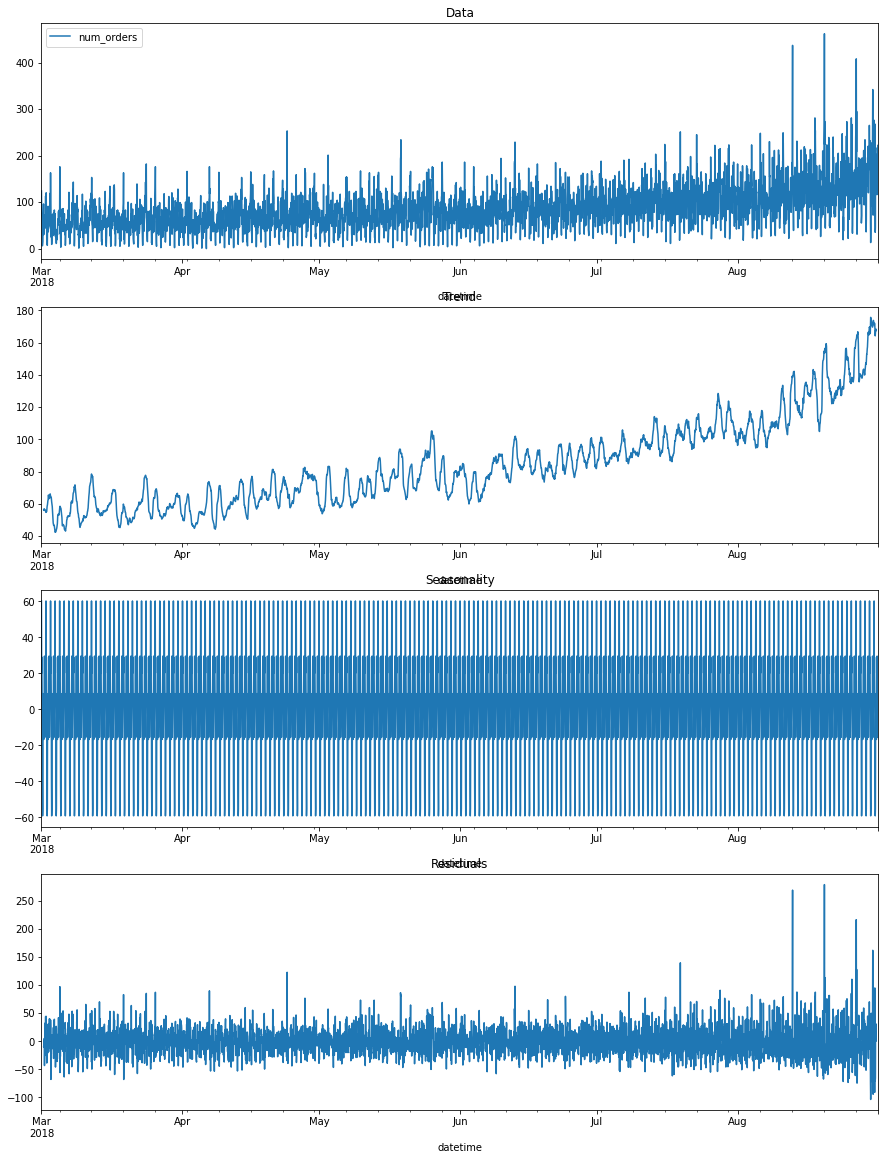

In [6]:
#decomposing date into seasonality, trend, and residuals subsets
decomposed = seasonal_decompose(df)

#plotting data and its seasonality, trend, and residuals
plt.figure(figsize=(15, 20))
plt.subplot(411)
df.plot(ax=plt.gca())
plt.title('Data')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

As can be seen there is in general ongoing trend over the given period and some seasonality, but the interval is too long to study it in more detail. So, we will plot the same but just for the last couple of weeks.

Text(0.5, 1.0, 'Residuals')

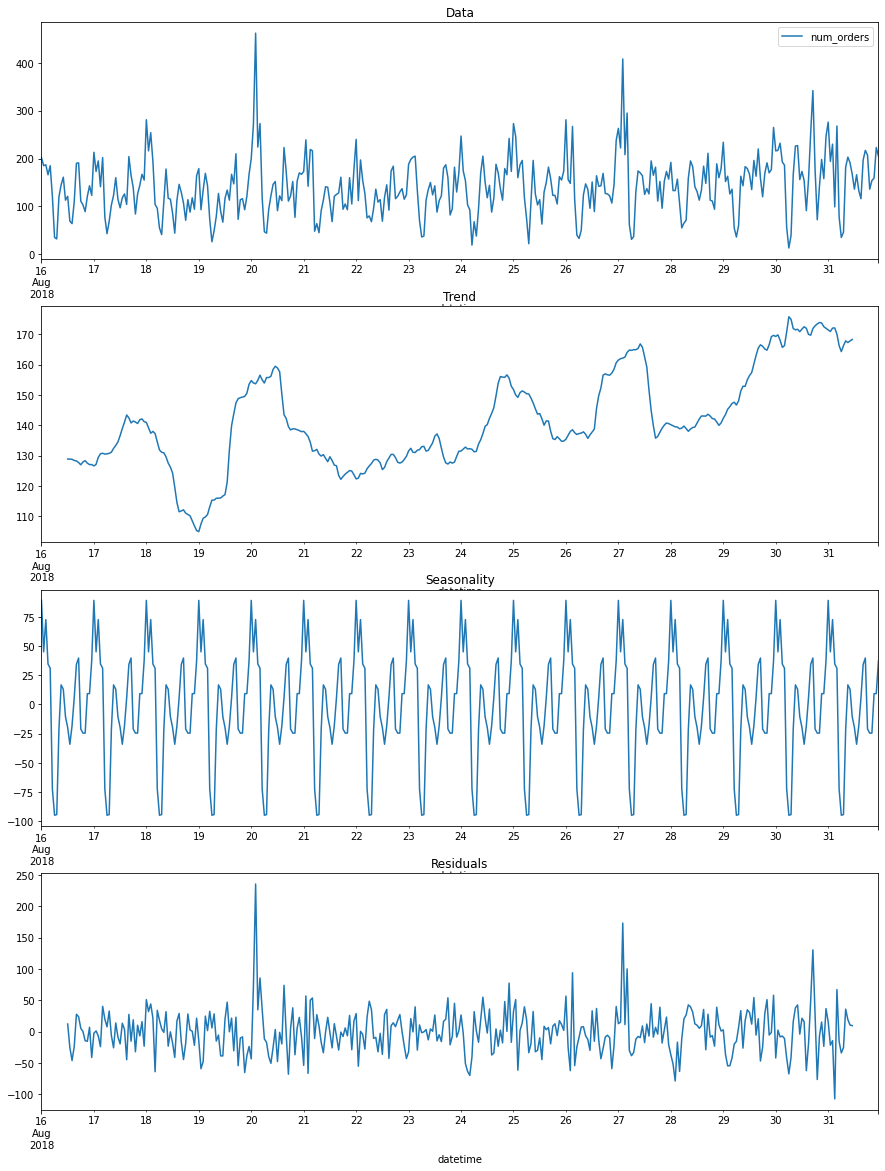

In [7]:
#decomposing date into seasonality, trend, and residuals subsets
decomposed = seasonal_decompose(df['2018-08-16':'2018-08-31'])

#plotting data and its seasonality, trend, and residuals
plt.figure(figsize=(15, 20))
plt.subplot(411)
df['2018-08-16':'2018-08-31'].plot(ax=plt.gca())
plt.title('Data')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

From the trend graph, it can be seen that the number of rides grows significantly on Friday and Sunday nights. This could be because many people fly on the weekend and return on Sunday. There is a daily seasonality, but the interval is still too big to describe it in more detail. Let’s plot only the seasonality graph just for a day.

Text(0.5, 1.0, 'Seasonality')

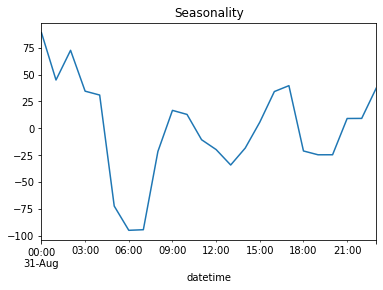

In [8]:
#plotting seasonality
decomposed.seasonal['2018-08-31':'2018-08-31'].plot()
plt.title('Seasonality')

As can be seen, there are usually more rides around 9:00, 17:00, and midnight. And there are fewer rides around 6:00. This makes sense as usually there are almost no flights at that time.

## Training and testing

In this final stage, we will train different models with different hyperparameters and will try to achieve the RMSE metric on the test set of not more than 48. First, we will add features to our data set. Since we predict hourly orders, we will add month, day, day of week, and hour. Also, since we observe that the number of orders varies on different days of the week, we will add 7-day lags. In addition, we will add the moving average.

In [9]:
# defining function to add features to a data set
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']=data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

#adding features to the data set.
make_features(df, 7, 10)

#splitting the data set to train and testing target and features subsets
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train_t=train['num_orders']
train_f=train.drop('num_orders', axis=1)
test_t=test['num_orders']
test_f=test.drop('num_orders', axis=1)

Let's confirm that the features were added correctly.

In [10]:
#displaying fist 10 rows of the data set
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,NaN


The first model that we will train is LinearRegression.

In [11]:
#training LinearRegression model and culculating RMSE
model=LinearRegression()
model.fit(train_f,train_t)
train_p=model.predict(train_f)
(mean_squared_error(train_t, train_p))**0.5

30.38102059386005

In [12]:
#testing LinearRegression model
test_p=model.predict(test_f)
(mean_squared_error(test_t, test_p))**0.5

53.14455212541846

RMSE of the LinearRegression model on the test set is far from our target. Next, we will train the DecisionTree model, but before doing this we will build a scorer to help us to tune the parameters.

In [13]:
#defining a function to calculate RMSE and building a scorer
def rmse(target, predictions):
    return (mean_squared_error(target, predictions))**0.5    
scorer=make_scorer(rmse, greater_is_better=False) 

In [14]:
#training DecisionTree models and tuning parametrs
best_max_depth=0
best_score=-10000

#defining time series split
tscv = TimeSeriesSplit(n_splits=3)

#training models with different max_depth in range from 2 to 30.
for i in range(2,30):
    model = DecisionTreeRegressor(random_state=12345, max_depth=i) 
    score=cross_val_score(model, train_f, train_t, scoring=scorer, cv=tscv)
#if score of the model is greater than previus best score, updating best max_depth and best score variables
    if score.mean()>best_score:
        best_max_depth=i
        best_score=score.mean()
print(f'Best score {best_score} is achived with max_depth={best_max_depth}')

Best score -32.53100968193363 is achived with max_depth=9


In [15]:
#testing DecisionTree model
model=DecisionTreeRegressor(random_state=12345, max_depth=9)
model.fit(train_f,train_t)
test_p=model.predict(test_f)
rmse(test_t, test_p)

50.236127574545556

RMSE of the Decision tree model on the test set is better, but still far from our target. Next, we will train the Random forest model.

In [16]:
#training RandomForest models and tuning parametrs
best_n_estimators=0
best_score=-10000
best_max_depth=0
#training models with different numbers of estimators and different max_depth.
for i in range(3,30):
    for j in range(3,15):
        model = RandomForestRegressor(random_state=12345, max_depth=j, n_estimators=i) 
        score=cross_val_score(model, train_f, train_t, scoring=scorer, cv=tscv)
#if score of the model is greater than previus best score, updating best n_estimators and best score variables
        if score.mean()>best_score:
            best_n_estimators=i
            best_max_depth=j
            best_score=score.mean()
print(f'Best score {best_score} is achived with n_estimators={best_n_estimators}, max_depth={best_max_depth}')

Best score -27.295477258700583 is achived with n_estimators=21, max_depth=13


In [17]:
#testing RandomForest model
model=RandomForestRegressor(random_state=12345, max_depth=13, n_estimators=21)
model.fit(train_f,train_t)
test_p=model.predict(test_f)
rmse(test_t, test_p)

46.95492817211032

RMSE of the Random Forest model on the test set is less than 48 so, our target is achieved. Let's see if we can achive even better result using model.

In [18]:
#training LGBM models and tuning parametrs    
model=LGBMRegressor()

#defining time series split
tscv = TimeSeriesSplit(n_splits=2)

#defining parameters for grid search
param={ 'n_estimators': [21],
        'max_depth' : [13],
        'learning_rate': [0.01, 0.05, 0.1, 0.5],    
        'objective': ['RMSE'],
        'random_seed': [12345]}

#finding the best parameters
grid=GridSearchCV(estimator=model, param_grid=param, scoring=scorer, cv=tscv, n_jobs=-1)
grid.fit(train_f, train_t)
best_param=grid.best_params_
best_param

{'learning_rate': 0.5,
 'max_depth': 13,
 'n_estimators': 21,
 'objective': 'RMSE',
 'random_seed': 12345}

In [19]:
#testing LGBM model
model=LGBMRegressor(n_estimators=21, max_depth=13, learning_rate=0.5, objective='RMSE', random_seed=12345) 
model.fit(train_f, train_t)
test_p=model.predict(test_f)
rmse(test_t, test_p)

46.00542979292839

RMSE of the LGBM model on the test set is also less than 48 and even better than RMSE of the Random Forest

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [X]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48